# Анализ результатов A/A/B-теста  пользователей мобильного приложения

<a id = 'section1'></a>
# Оглавление

<a class="ancor" id="step_0"></a>
* [Цель и предмет исследования](#step_1)
* [1  Загрузка данных и изучение общей информации](#step_2)
* [2  Подготовка данных](#step_3)
* [3  Изучение и проверка данных](#step_4)
* [4  Изучение воронки событий](#step_5)
* [5  Изучение результатов эксперимента](#step_6)
* [ВЫВОДЫ](#step_7)

<a class="ancor" id="step_1"></a>
**Цель**: изучить поведение пользователей мобильного приложения стартапе, который продаёт продукты питания, в случае замены шрифта во всем приложении на основании A/A/B-теста (2 контрольные группы со старыми шрифтами А и одна экспериментальная — с новыми шрифтами В) и выяснить какой шрифт лучше.


**Предмет исследования**: файл logs_exp.csv

*Путь к файлу*: /datasets/logs_exp.csv.

*Описание данных*

EventName — название события;                                                              
DeviceIDHash — уникальный идентификатор пользователя;                                      
EventTimestamp — время события;                                                            
ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.     

<a href = '#section1'>Вернуться к оглавлению</a>
</div>

<a class="ancor" id="step_2"></a>
## Загрузка данных  и изучение общей информации

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math as mth
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


Загружены необходимые для анализа библиотеки

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t') #, decimal=',')
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


При считывании файла  потребовалось дополнительно использование разделителя sep='\t'

In [3]:
print('Общая информация')
print(data.info())
print()
print('Количество полных строчных дубликатов:', data.duplicated().sum())

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None

Количество полных строчных дубликатов: 413


В логе есть полные строчные дубликаты, их  менее 1%, удалим их из датасета.

Пропусков нет.

В названии столбцов присутствуют заглавные буквы, заменим их на более удобные.

Типы  данных  корректны,  но время события приведено в формате Unix time в секундах, что неудобно для анализа, добавим дополнительные столбцы даты и времени и дат.

<a href = '#section1'>Вернуться к оглавлению</a>
</div>

<a class="ancor" id="step_3"></a>
## Подготовка  данных

In [4]:
data = data.drop_duplicates().reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
EventName         243713 non-null object
DeviceIDHash      243713 non-null int64
EventTimestamp    243713 non-null int64
ExpId             243713 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.4+ MB


Удалии дубликаты из лога

In [5]:
data.columns = ['name', 'user_id', 'timestamp', 'exp_id']
data.columns

Index(['name', 'user_id', 'timestamp', 'exp_id'], dtype='object')

Заменили наименования столбцов

In [6]:
data['date_time'] = pd.to_datetime(data['timestamp'], unit='s')
data['date'] = data['date_time'].astype('datetime64[D]')
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
name         243713 non-null object
user_id      243713 non-null int64
timestamp    243713 non-null int64
exp_id       243713 non-null int64
date_time    243713 non-null datetime64[ns]
date         243713 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


Добавлены столбец даты и времени и  столбец дат

<a href = '#section1'>Вернуться к оглавлению</a>
</div>

<a class="ancor" id="step_4"></a>
## Изучение и проверка данных

In [7]:
print('Количество событий в логе:', data.shape[0])
print('Количество пользователей в логе:', data['user_id'].nunique())
print('В среднем приходится на пользователя', \
      round(data.groupby('user_id')['name'].count().mean(), 0), 'события')
print('По медиане приходится на пользователя', \
      round(data.groupby('user_id')['name'].count().median(), 0), 'событий')

#data.shape[0] / data['user_id'].nunique()  второй способ расчета среднего

Количество событий в логе: 243713
Количество пользователей в логе: 7551
В среднем приходится на пользователя 32.0 события
По медиане приходится на пользователя 20.0 событий


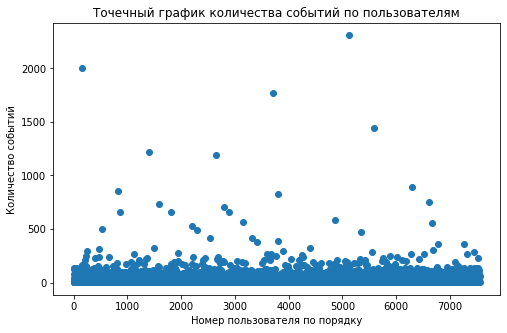

Перцентиль 95: 89
Перцентиль 99: 200


In [8]:
a= data.groupby('user_id')['name'].count().reset_index().rename(columns={'name': 'count'})

x_values = pd.Series(range(0,len(a)))

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(x_values, a['count'])
plt.xlabel('Номер пользователя по порядку')
plt.ylabel('Количество событий')
plt.title("Точечный график количества событий по пользователям")

plt.show()
a

a.describe()

percentile_a = np.percentile(a['count'], [95, 99]) 
print('Перцентиль 95: {0:.0f}'.format(percentile_a[0])) 
print('Перцентиль 99: {0:.0f}'.format(percentile_a[1]))

Хотелось бы обратить внимание, что в данных у нас есть выбросы и поэтому более объективно описывать число событий на одного пользователя будет медиана или перцентили,вместо среднего (согласно задания проекта). 

In [9]:
print('В логе данные за период:', data['date_time'].min(),'-',data['date_time'].max())

В логе данные за период: 2019-07-25 04:43:36 - 2019-08-07 21:15:17


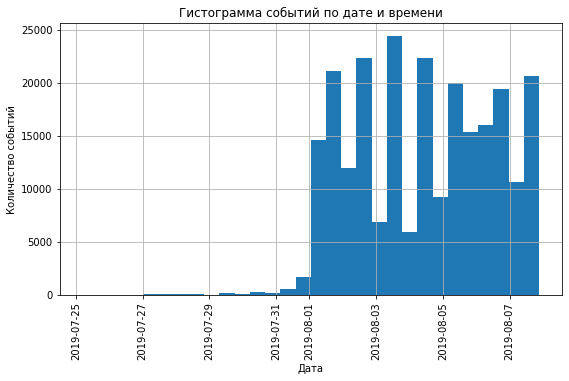

In [10]:
fig, test = plt.subplots()
data['date_time'].hist(bins=30)
test.set_title('Гистограмма событий по дате и времени')
test.set_xlabel('Дата')
test.set_ylabel('Количество событий')
fig.set_figheight(5) 
fig.set_figwidth(9) 
plt.xticks(rotation=90)
plt.show()

Из гистограммы видно, что до 31 июля данные неполные и их целесообразно отбросить.Возможно это связано с техническими проблемами и началом раскручивания приложения магазина (стартап). Но это может быть связано с проведением маркетинговой кампании/акции, что может привнести ошибку в выводы результатов теста. 

In [11]:
data.pivot_table(index='date',columns ='name',\
                    values='user_id', aggfunc='count')

name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
date,,,,,
2019-07-25,2.0,4.0,1.0,2.0,NaN
2019-07-26,6.0,16.0,4.0,3.0,2.0
2019-07-27,4.0,39.0,9.0,1.0,2.0
2019-07-28,24.0,53.0,16.0,12.0,NaN
2019-07-29,23.0,132.0,20.0,9.0,NaN
2019-07-30,49.0,279.0,51.0,33.0,NaN
2019-07-31,257.0,1250.0,374.0,140.0,9.0
2019-08-01,6217.0,17945.0,6988.0,4771.0,220.0
2019-08-02,6522.0,16792.0,6924.0,5148.0,168.0


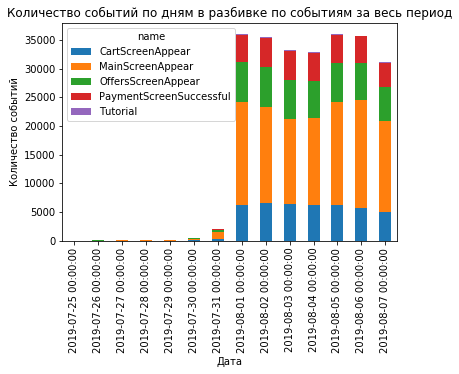

In [12]:
data.pivot_table(index='date',columns ='name',\
                    values='user_id', aggfunc='count').plot(kind='bar', stacked = True)
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title("Количество событий по дням в разбивке по событиям за весь период")
plt.xticks(rotation=90)
plt.show()

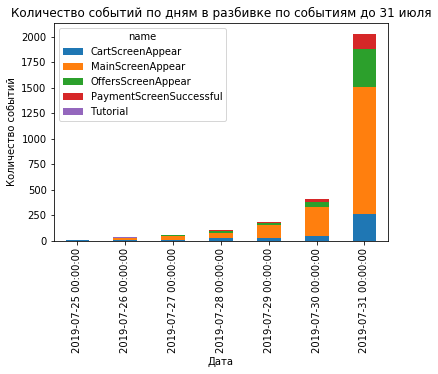

In [13]:
data[data['date'] <= '2019-07-31'].pivot_table(index='date',columns ='name',\
                    values='user_id', aggfunc='count').plot(kind='bar', stacked = True)
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title("Количество событий по дням в разбивке по событиям до 31 июля")
plt.xticks(rotation=90)
plt.show()

In [14]:
data_new = data[data['date'] > '2019-07-31']

print('Количество событий в логе, которые потеряли:', \
      data[data['date'] <= '2019-07-31'].shape[0])

print('Количество пользователей в логе, которые потеряли:', \
      (data['user_id'].nunique() - data_new['user_id'].nunique()))

print('Процент от исходных данных составляют отброшенные события:', \
      round(data[data['date'] <= '2019-07-31'].shape[0] / data.shape[0] * 100, 2))

print('Процент от исходных данных составляют отброшенные пользователи:', \
      round((data['user_id'].nunique() - data_new['user_id'].nunique()) / \
            data['user_id'].nunique() * 100, 2))


Количество событий в логе, которые потеряли: 2826
Количество пользователей в логе, которые потеряли: 17
Процент от исходных данных составляют отброшенные события: 1.16
Процент от исходных данных составляют отброшенные пользователи: 0.23


In [15]:
print('Количество событий в очищенном логе:', data_new.shape[0])
print('Количество пользователей в в очищенном логе:', data_new['user_id'].nunique())
print('В среднем приходится на пользователя', \
      round(data_new.groupby('user_id')['name'].count().mean(), 0), 'события в очищенном логе')

Количество событий в очищенном логе: 240887
Количество пользователей в в очищенном логе: 7534
В среднем приходится на пользователя 32.0 события в очищенном логе


In [16]:
data_new.groupby('exp_id')['user_id'].nunique().sort_values(ascending=False)

exp_id
248    2537
247    2513
246    2484
Name: user_id, dtype: int64

В очищенном логе есть пользователи всех трех экспериментальных групп, их количество сопоставимо

ВЫВОД
    
В логе мобильного приложения магазина продуктов питания за период проведения A/A/B-теста, а именно: 25.07.2019 - 08.07.2019 представлена информация о 243713 событиях/действиях, при этом количество  уникальных пользователей в логе 7551 и в среднем приходится на одного пользователя 32 события.
Однако, из анализируемого лога были удалены данные до 31 июля включительно, т.к. до этого периода данные были неполные. При этом была утеряна информация, включающая данные о 2826 событиях (1,1 % от общего количества) и 17 пользователях (0,2%), что не является критичным для точности исследования.
Таким образом,  далее будем анализировать результаты А/А/В  в логе, который содержит 240887 событие за период: 1.08.2019 - 08.07.2019, при этом количество пользователей составляет 7534, в среднее значение событий на одного пользователя сообытий осталось тоже, 32.

<a href = '#section1'>Вернуться к оглавлению</a>
</div>

<a class="ancor" id="step_5"></a>
## Изучение воронки событий

In [17]:
data_new.pivot_table(index='name',values = 'user_id', aggfunc = 'count')\
                                    .rename(columns={'user_id': 'count'}).\
                                    sort_values(by='count', ascending=False).reset_index()

,name,count
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


In [18]:
data_new.groupby('name')['user_id'].nunique().sort_values(ascending=False).reset_index()

,name,user_id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


Исходя из полученных данных можно предположить, что события происходят в следующем порядке:

1	MainScreenAppear (Главный экран)                                              
2	OffersScreenAppear (Экран предложений)                                                
3	CartScreenAppear (Экран корзины)                                         
4	PaymentScreenSuccessful (Платеж прошел успешно)


Событие Tutorial (Руководство, инструкция)опционален и не выстраивается в воронку событий.

In [19]:
print('Главный экран:', \
      round(data_new[data_new['name'] ==  'MainScreenAppear']['user_id'].nunique() / \
       data_new['user_id'].nunique()*100,2), '%')

print('Экран предложений:', \
      round(data_new[data_new['name'] ==  'OffersScreenAppear']['user_id'].nunique() / \
       data_new[data_new['name'] ==  'MainScreenAppear']['user_id'].nunique()*100,2),'%')

print('Экран корзины:', \
      round(data_new[data_new['name'] ==  'CartScreenAppear']['user_id'].nunique() / \
       data_new[data_new['name'] ==  'OffersScreenAppear']['user_id'].nunique()*100,2),'%')

print('Платеж прошел успешно:', \
      round(data_new[data_new['name'] ==  'PaymentScreenSuccessful']['user_id'].nunique() / \
       data_new[data_new['name'] ==  'CartScreenAppear']['user_id'].nunique()*100,2),'%')

print()
print('Доля пользователей, которая доходит от главной страницы до оплаты:', \
      round(data_new[data_new['name'] ==  'PaymentScreenSuccessful']['user_id'].nunique() / \
       data_new[data_new['name'] ==  'MainScreenAppear']['user_id'].nunique()*100,2),'%')

Главный экран: 98.47 %
Экран предложений: 61.91 %
Экран корзины: 81.3 %
Платеж прошел успешно: 94.78 %

Доля пользователей, которая доходит от главной страницы до оплаты: 47.7 %


Больше всего пользователей теряется при переходе от Главного экрана к Странице предложений 

ВЫВОД
    
События/действия пользователей предположительно выстраиваются в последовательную цепочку:
Главный экран: 98.47 %                                                                     
Экран предложений: 61.91 %                                                                
Экран корзины: 81.3 %                                                                    
Платеж прошел успешно: 94.78 %.                                                            
    
Доля пользователей, которая доходит от главной страницы до оплаты: 47.7 %.
    
Больше всего пользователей теряется при переходе от Главного экрана к Странице предложений.

Событие Tutorial (Руководство, инструкция) не выстраивается в воронку событий.

<a href = '#section1'>Вернуться к оглавлению</a>
</div>

<a class="ancor" id="step_6"></a>
## Изучение результатов эксперимента

Изучим насколько успешно прошел А/А/B-тест по критериям:

1. Количество пользователей в различных группах различается не более, чем на 1%;
2. Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же; 
3. Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости; 
4. Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.



In [20]:
group = data_new.groupby('exp_id')['user_id'].nunique()\
.sort_values(ascending=False).reset_index()

group['%']= round(group['user_id'] / group['user_id'].sum() * 100, 2)
group

,exp_id,user_id,%
0,248,2537,33.67
1,247,2513,33.36
2,246,2484,32.97


**Количество пользователей в различных группах различается не более, чем на 1%**

In [21]:
group_246 = data_new[data_new['exp_id'] == 246]
group_247 = data_new[data_new['exp_id'] == 247]
group_248 = data_new[data_new['exp_id'] == 248]

print('Проверка на уникальность пользователей в группах')
print()
print('Пересечение пользователей в группах 246 и 247:', group_247[group_247['user_id'].\
                                isin(group_246['user_id'].tolist())]['user_id'].count())
print('Пересечение пользователей в группах 247 и 248:', group_248[group_248['user_id'].
                                isin(group_247['user_id'].tolist())]['user_id'].count())
print('Пересечение пользователей в группах 247 и 248:',group_248[group_248['user_id'].\
                                isin(group_246['user_id'].tolist())]['user_id'].count())

Проверка на уникальность пользователей в группах

Пересечение пользователей в группах 246 и 247: 0
Пересечение пользователей в группах 247 и 248: 0
Пересечение пользователей в группах 247 и 248: 0


**Попавший в одну из групп посетитель остаётся в группе до конца теста**

In [22]:
data_event = data_new.pivot_table(index='name', columns='exp_id',\
                             values='user_id', aggfunc='nunique').reset_index()
data_event.columns = ['name', '246', '247', '248']
data_event['246+247'] = data_event['246'] + data_event['247']
data_event['246%'] = round(data_event['246'] / data_event['246'].sum() * 100, 2)
data_event['247%'] = round(data_event['247'] / data_event['247'].sum() * 100, 2)
data_event['248%'] = round(data_event['248'] / data_event['248'].sum() * 100, 2)
data_event['246+247%'] = round(data_event['246+247'] / data_event['246+247'].sum() * 100, 2)
data_event

,name,246,247,248,246+247,246%,247%,248%,246+247%
0,CartScreenAppear,1266,1238,1230,2504,18.79,18.55,18.32,18.67
1,MainScreenAppear,2450,2476,2493,4926,36.37,37.09,37.13,36.73
2,OffersScreenAppear,1542,1520,1531,3062,22.89,22.77,22.80,22.83
3,PaymentScreenSuccessful,1200,1158,1181,2358,17.81,17.35,17.59,17.58
4,Tutorial,278,283,279,561,4.13,4.24,4.16,4.18


**Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же**

Ключевая метрика в нашем случае: какая доля  пользователей совершила покупку на каждом этапе воронки продаж.  Сравнить доли  со статистической значимостью можно  посредством гипотезы о равенстве долей в тестируемых группах. Разница между пропорциями, наблюдаемыми в тестах 246, 247, 248, будет нашей статистикой. 

 **Но** гипотеза: доли пользователей для тестируемых групп, которые оплатили заказ, равны для события ( 'MainScreenAppear', 'CartScreenAppear', 'OffersScreenAppear'), т.е. нет разница в конверсии из какого либо этапа (события)  воронки в оплату.

 **Н1** гипотеза: между долями пользователей, которые оплатили заказ,  есть значимая разница, т.е. есть разница в конверсии из какого либо этапа  воронки в оплату.

Для автоматизации проверки напишем функцию для сравнения долей с помощью z-статистики , в которой:
a - уровень значимости,                                                                     group_1, group_1 - группы теста  (246, 247,248),                                           
name - событие для которого считается конверсия в оплату.                                   

In [23]:
def z(a, group_1, group_2, name):
    alpha =  a 
    part_1 =  data_new[data_new['exp_id']==group_1].pivot_table(index='date',\
                           columns='name',values='user_id',aggfunc='nunique')
             
    part_2 =  data_new[data_new['exp_id']==group_2].pivot_table(index='date',\
                           columns='name',values='user_id',aggfunc='nunique')
    
    success= np.array([part_1['PaymentScreenSuccessful'].mean(), \
                       part_2['PaymentScreenSuccessful'].mean()])
    
    event = np.array([part_1[name].mean(), part_2[name].mean()])
    
    p1 = success[0] / event[0] 
    p2 = success[1] / event[1]
    
    p_combained = (success[0] + success[1])/(event[0] + event[1])
    difference = p1 - p2
    
    z_value = difference / mth.sqrt(p_combained*(1-p_combained)*\
                                (1/event[0]+1/event[1]))
    
    distr = st.norm(0,1)
    p_value = (1 - distr.cdf(abs(z_value)))*2
    
    print(f'Группы: {group_1, group_2}, Событие: {name}, Значение alpha: {alpha}')
    
    print('p-value:', p_value)
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу,нет оснований считать доли разными')
    
    print()

In [24]:
events = ['MainScreenAppear', 'CartScreenAppear', 'OffersScreenAppear']

for e in events:
    z(0.01, 246, 247, e) 
    z(0.01, 246, 248, e)
    z(0.01, 247, 248, e)

Группы: (246, 247), Событие: MainScreenAppear, Значение alpha: 0.01
p-value: 0.4147494746072766
Не получилось отвергнуть нулевую гипотезу,нет оснований считать доли разными

Группы: (246, 248), Событие: MainScreenAppear, Значение alpha: 0.01
p-value: 0.5480055947135316
Не получилось отвергнуть нулевую гипотезу,нет оснований считать доли разными

Группы: (247, 248), Событие: MainScreenAppear, Значение alpha: 0.01
p-value: 0.8278352798067137
Не получилось отвергнуть нулевую гипотезу,нет оснований считать доли разными

Группы: (246, 247), Событие: CartScreenAppear, Значение alpha: 0.01
p-value: 0.6440159148182185
Не получилось отвергнуть нулевую гипотезу,нет оснований считать доли разными

Группы: (246, 248), Событие: CartScreenAppear, Значение alpha: 0.01
p-value: 0.9625391032858244
Не получилось отвергнуть нулевую гипотезу,нет оснований считать доли разными

Группы: (247, 248), Событие: CartScreenAppear, Значение alpha: 0.01
p-value: 0.6110047691703075
Не получилось отвергнуть нулевую г

В результатах А/А- теста ( группы 246 и 247) нет существенных различий,**группы поделены корректно.** 
Результаты А/B теста  свидетельствуют, что изменение шрифта не оказывает влияния на конверсию любого из событий на покупку. Т.е. **на покупательскую способность изменение шрифта не влияет.** 

In [25]:
def z1(a, name):
    alpha =  a
    part_1 =  data_new[data_new['exp_id'].isin((246,247))].pivot_table(index='date',\
                           columns='name',values='user_id',aggfunc='nunique')     
    
    part_2 =  data_new[data_new['exp_id']==248].pivot_table(index='date',\
                           columns='name',values='user_id',aggfunc='nunique')
    success= np.array([part_1['PaymentScreenSuccessful'].mean(),\
                       part_2['PaymentScreenSuccessful'].mean()])
    
    event = np.array([part_1[name].mean(), part_2[name].mean()])
    
    p1 = success[0] / event[0] 
    p2 = success[1] / event[1]
    
    p_combained = (success[0] + success[1])/(event[0] + event[1])
    difference = p1 - p2
    
    z_value = difference / mth.sqrt(p_combained*(1-p_combained)*\
                                (1/event[0]+1/event[1]))
 
    distr = st.norm(0,1)
    p_value = (1 - distr.cdf(abs(z_value)))*2
    
    print(f'Группы: (246+247, 248), Событие: {name}, Значение alpha: {alpha}')
    
    print('p-value:', p_value)
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу,нет оснований считать доли разными')
 

Функция для проверки статистической значимости в  объединенной группе 246 с 247 (А) и 248 (В).

In [26]:
for e in events:
    z1(0.01, e)

Группы: (246+247, 248), Событие: MainScreenAppear, Значение alpha: 0.01
p-value: 0.8270263625099985
Не получилось отвергнуть нулевую гипотезу,нет оснований считать доли разными
Группы: (246+247, 248), Событие: CartScreenAppear, Значение alpha: 0.01
p-value: 0.747857096906104
Не получилось отвергнуть нулевую гипотезу,нет оснований считать доли разными
Группы: (246+247, 248), Событие: OffersScreenAppear, Значение alpha: 0.01
p-value: 0.7945830522543631
Не получилось отвергнуть нулевую гипотезу,нет оснований считать доли разными


Проверка статистической значимости в  объединенной группе 246 с 247 (А) и 248 (В) не выявила различие в долях групп (объединенной и с измененным шрифтом) при вероятности ошибки в 1%.

При проверке гипотез был выбран уровень значимости 0,01 (1%), т.е.  каждый сотый раз  можно получать ложный результат. Было сделано 16 проверок, учитывая объединенную группу. В принципе, с практической точки зрения можно  на таком уровне значимости остановиться. Но учитывая большой объем выборки, в которой более тысячи пользователей для любого из этапа воронки, уверенно отвергать нулевую гипотезу целесообразно только при значимости меньшей 0,001. Основываясь на ранее сделанных расчетах p-value можно констатировать, что нулевая гипотеза  не будет отвергнута при уровне значимости 0,001, равно как и при большем  уровне значимости 0,05 (расчеты смотри ниже).

In [27]:
for e in events:
    z(0.001, 246, 247, e) 
    z(0.001, 246, 248, e)
    z(0.001, 247, 248, e)

Группы: (246, 247), Событие: MainScreenAppear, Значение alpha: 0.001
p-value: 0.4147494746072766
Не получилось отвергнуть нулевую гипотезу,нет оснований считать доли разными

Группы: (246, 248), Событие: MainScreenAppear, Значение alpha: 0.001
p-value: 0.5480055947135316
Не получилось отвергнуть нулевую гипотезу,нет оснований считать доли разными

Группы: (247, 248), Событие: MainScreenAppear, Значение alpha: 0.001
p-value: 0.8278352798067137
Не получилось отвергнуть нулевую гипотезу,нет оснований считать доли разными

Группы: (246, 247), Событие: CartScreenAppear, Значение alpha: 0.001
p-value: 0.6440159148182185
Не получилось отвергнуть нулевую гипотезу,нет оснований считать доли разными

Группы: (246, 248), Событие: CartScreenAppear, Значение alpha: 0.001
p-value: 0.9625391032858244
Не получилось отвергнуть нулевую гипотезу,нет оснований считать доли разными

Группы: (247, 248), Событие: CartScreenAppear, Значение alpha: 0.001
p-value: 0.6110047691703075
Не получилось отвергнуть нул

In [28]:
for e in events:
    z(0.05, 246, 247, e) 
    z(0.05, 246, 248, e)
    z(0.05, 247, 248, e)

Группы: (246, 247), Событие: MainScreenAppear, Значение alpha: 0.05
p-value: 0.4147494746072766
Не получилось отвергнуть нулевую гипотезу,нет оснований считать доли разными

Группы: (246, 248), Событие: MainScreenAppear, Значение alpha: 0.05
p-value: 0.5480055947135316
Не получилось отвергнуть нулевую гипотезу,нет оснований считать доли разными

Группы: (247, 248), Событие: MainScreenAppear, Значение alpha: 0.05
p-value: 0.8278352798067137
Не получилось отвергнуть нулевую гипотезу,нет оснований считать доли разными

Группы: (246, 247), Событие: CartScreenAppear, Значение alpha: 0.05
p-value: 0.6440159148182185
Не получилось отвергнуть нулевую гипотезу,нет оснований считать доли разными

Группы: (246, 248), Событие: CartScreenAppear, Значение alpha: 0.05
p-value: 0.9625391032858244
Не получилось отвергнуть нулевую гипотезу,нет оснований считать доли разными

Группы: (247, 248), Событие: CartScreenAppear, Значение alpha: 0.05
p-value: 0.6110047691703075
Не получилось отвергнуть нулевую г

In [29]:
for e in events:
    z1(0.001, e)

Группы: (246+247, 248), Событие: MainScreenAppear, Значение alpha: 0.001
p-value: 0.8270263625099985
Не получилось отвергнуть нулевую гипотезу,нет оснований считать доли разными
Группы: (246+247, 248), Событие: CartScreenAppear, Значение alpha: 0.001
p-value: 0.747857096906104
Не получилось отвергнуть нулевую гипотезу,нет оснований считать доли разными
Группы: (246+247, 248), Событие: OffersScreenAppear, Значение alpha: 0.001
p-value: 0.7945830522543631
Не получилось отвергнуть нулевую гипотезу,нет оснований считать доли разными


In [31]:
for e in events:
    z1(0.05, e)

Группы: (246+247, 248), Событие: MainScreenAppear, Значение alpha: 0.05
p-value: 0.8270263625099985
Не получилось отвергнуть нулевую гипотезу,нет оснований считать доли разными
Группы: (246+247, 248), Событие: CartScreenAppear, Значение alpha: 0.05
p-value: 0.747857096906104
Не получилось отвергнуть нулевую гипотезу,нет оснований считать доли разными
Группы: (246+247, 248), Событие: OffersScreenAppear, Значение alpha: 0.05
p-value: 0.7945830522543631
Не получилось отвергнуть нулевую гипотезу,нет оснований считать доли разными


<a href = '#section1'>Вернуться к оглавлению</a>
</div>

<a class="ancor" id="step_7"></a>
# ВЫВОДЫ

Итак, для достижения поставленной цели: выявления влияния изменения шрифта на покупательскую способность был изучен лог мобильного приложения  магазина продуктов питания за период проведения A/A/B-теста, а именно: 25.07.2019 - 08.07.2019.

В анализируемых данных пропусков не было, типы данных были представлены корректно. Для удобства анализа были заменены названия столбцов и добавлены  дополнительные столбцы даты и времени и дат, т.к. время события фиксировалось в формате Unix time в секундах.
Из анализируемого лога были удалены строчные дубликаты в размере 1% и данные до 31 июля включительно, т.к.до этого периода данные были неполные. При этом была утеряна информация, включающая данные о  2826 событий (1,1 % от общего количества) и 17 пользователях (0,2%), что не является критичным для точности исследования. 

Таким образом, был проанализирован актуальный для целей проекта лог, который содержал  240887 событие  за период: 1.08.2019 - 08.07.2019. При этом количество пользователей в очищенном логе составляло 7534, в среднем приходилось на пользователя 32 событий/действий (медианное значение).

Пересечения в группах не выявлено, различие в количестве пользователей в группах составило не более, чем 1%.
Для всех групп фиксировались данные об одних и техже событиях/действиях в сопоставимых пропорциях:MainScreenAppear (Главный экран), OffersScreenAppear (Экран предложений), CartScreenAppear (Экран корзины), PaymentScreenSuccessful (Платеж прошел успешно),Tutorial (Руководство, инструкция).

Для достижения поставленных целей была составлена воронка продаж и изучена конверсия покупателей на каждом этапе. Статистическая значимость результатов A/A/B-теста  была оценена посредством проверки гипотезы о равенстве долей в тестируемых группах, критерий значимости был выбран 1%.

В итоге:
1. События/действия пользователей предположительно выстраиваются в  последовательную цепочку:  
Главный экран: 98.47 %                                                                     
Экран предложений: 61.91 %                                                                 
Экран корзины: 81.3 %                                                                      
Платеж прошел успешно: 94.78 %.                                                             
Доля пользователей, которая доходит от главной страницы до оплаты: 47.7 %
Больше всего пользователей теряется при переходе от Главного экрана к Странице предложений.
Событие Tutorial (Руководство, инструкция) не выстраивается в воронку событий.
2. В результатах А/А- теста нет существенных различий,группы поделены корректно. 
3. Результаты А/B теста свидетельствуют, что изменение шрифта не оказывает влияния на конверсию любого из событий на покупку. Т.е. на покупательскую способность изменение шрифта не влияет. Проверка статистической значимости в  объединенной контрольной группе и группе с измененным шрифтом также не выявила различие в долях групп при вероятности ошибки 1%.


<a href = '#section1'>Вернуться к оглавлению</a>
</div>